In [1]:
import numpy as np
import derpy
from time import sleep
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Calibrating Rotations with an Air Measurement

Here we will illustrate the calibration of Derp with an air measurement using the Q data reduction. It will in many ways be indistinguishable from a real measurement. The only difference is that we treat the sample as known and try to fit to it. 

# Initialize Camera and Stages

In [2]:
cam = derpy.CRED2(set_temperature=-40, fps=10, tint=90) # TODO: add units to docstring (also add docstring)

Updating...
Sensor Temperature: -39.98C
Motherboard Temperature: 37.75C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.25C
Peltier Temperature: 14.08C
Heatsink Temperature: 39.92C
***********************
Sensor Temperature: -39.98C
Motherboard Temperature: 37.75C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.5C
Peltier Temperature: 14.08C
Heatsink Temperature: 39.92C
***********************
Sensor Temperature: -39.98C
Motherboard Temperature: 37.75C
Frontend Temperature: 41.75C
Powerboard Temperature: 44.5C
Peltier Temperature: 14.08C
Heatsink Temperature: 39.92C
***********************
Sensor Temperature: -39.97C
Motherboard Temperature: 37.75C
Frontend Temperature: 41.5C
Powerboard Temperature: 44.5C
Peltier Temperature: 14.08C
Heatsink Temperature: 39.93C
***********************
Sensor Temperature: -39.98C
Motherboard Temperature: 37.75C
Frontend Temperature: 41.75C
Powerboard Temperature: 44.5C
Peltier Temperature: 14.07C
Heatsink Temperature: 39.96C
**************

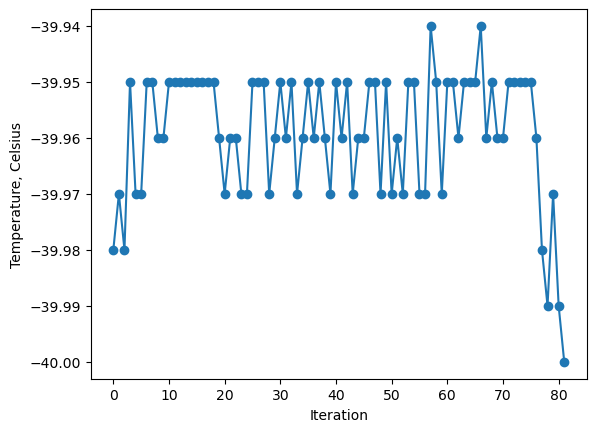

In [18]:
plt.figure()
plt.plot(cam.temperature_change, marker='o')
plt.ylabel('Temperature, Celsius')
plt.xlabel('Iteration')
plt.show()

In [5]:
median_img = cam.take_median_image(n_frames=10)
print(median_img.shape)
plt.imshow(median_img, cmap='gray') 

AttributeError: 'CRED2' object has no attribute 'take_median_image'

In [6]:
psg_stg = derpy.PSGRotationStage()
psa_stg = derpy.PSARotationStage()

In [7]:
cam.tint = 90

Prior camera tint: 0.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.0100002750.

# Take a Dark Image

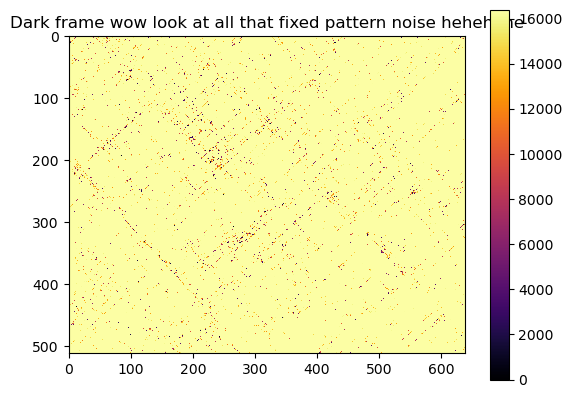

In [8]:
dark = cam.take_many_images(10)
dark_avg = np.median(dark, axis=0)

plt.figure()
plt.title('Dark frame wow look at all that fixed pattern noise hehehehe')
plt.imshow(dark_avg, vmax=2**14, cmap='inferno')
plt.colorbar()

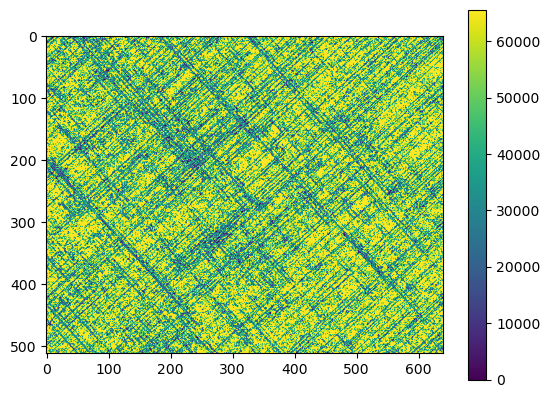

In [17]:
plt.imshow(cam.take_image()[0])
plt.colorbar()

90.00104300000001

In [12]:
2**14

16384

# Turn on laser here and take image

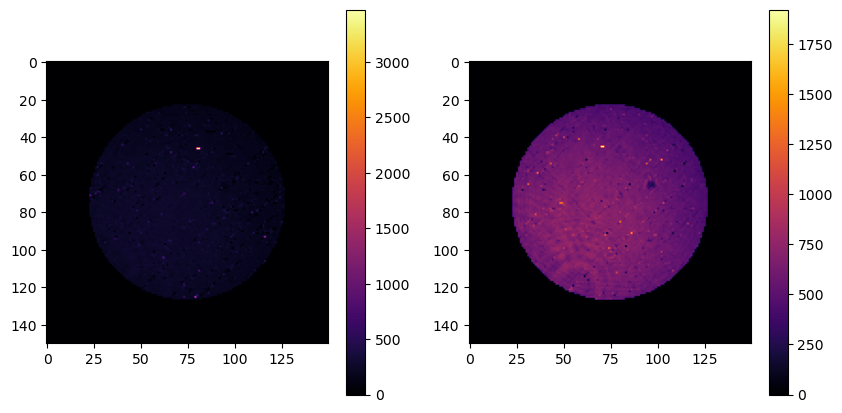

In [161]:
bright = cam.take_many_images(10)
bright_avg = np.mean(bright, axis=0) - dark_avg
bright_avg[bright_avg < 0] = 0
cxr, cyr = 200, 400
cxl, cyl = 200, 200
cut = 75

x = np.linspace(-1,1,2*cut)
x, y = np.meshgrid(x, x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask[r < 0.7] = 1

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(mask * bright_avg[cxl-cut:cxl+cut,cyl-cut:cyl+cut], cmap='inferno')
plt.colorbar()
plt.subplot(122)
plt.imshow(mask * bright_avg[cxr-cut:cxr+cut,cyr-cut:cyr+cut], cmap='inferno')
plt.colorbar()
plt.show()

## Set up DRRP measurement of air

In [ ]:
ANGULAR_RATIO = 2.5
STEPS_DEG = 5

angles_psg = np.arange(0, 181 + STEPS_DEG, STEPS_DEG)
angles_psa = angles_psg * ANGULAR_RATIO

power_left = []
power_right = []

for th in angles_psg:

    psg_stg.step(STEPS_DEG)
    sleep(0.1)
    psa_stg.step(STEPS_DEG * ANGULAR_RATIO)
    sleep(0.1)

    # 
    _b = cam.take_many_images(10)
    _bm = np.mean(_b, axis=0) - dark_avg
    _bm[_bm < 0] = 1e-10
    power_left.append(np.mean(_bm[cxl-cut:cxl+cut, cyl-cut:cyl+cut][mask==1]))
    power_right.append(np.mean(_bm[cxr-cut:cxr+cut, cyr-cut:cyr+cut][mask==1]))


# Rotate the PSG waveplate and take images

In [20]:
STEPS_DEG = 5
angles_psg = np.arange(0, 180 + STEPS_DEG, STEPS_DEG)

power_psg_left = []
power_psg_right = []

for th in angles_psg:

    psg_stg.step(STEPS_DEG)
    sleep(0.1)
    _b = cam.take_many_images(10)
    _bm = np.mean(_b, axis=0) - dark_avg
    _bm[_bm < 0] = 1e-10
    power_psg_left.append(np.mean(_bm[cxl-cut:cxl+cut, cyl-cut:cyl+cut][mask==1]))
    power_psg_right.append(np.mean(_bm[cxr-cut:cxr+cut, cyr-cut:cyr+cut][mask==1]))

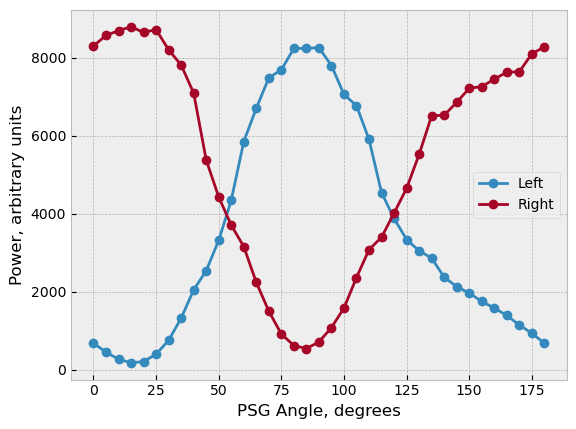

In [21]:
plt.style.use('bmh')
plt.figure()
plt.plot(angles_psg, power_psg_left, label='Left', marker='o')
plt.plot(angles_psg, power_psg_right, label='Right', marker='o')
plt.xlabel('PSG Angle, degrees')
plt.ylabel('Power, arbitrary units')
plt.legend()
plt.show()

# Rotate the PSA waveplate and take images

In [22]:
angles_psa = np.arange(0, 180 + STEPS_DEG, STEPS_DEG)

power_psa_left = []
power_psa_right = []

for th in angles_psg:

    psa_stg.step(STEPS_DEG)
    sleep(0.1)
    _b = cam.take_many_images(10)
    _bm = np.mean(_b, axis=0) - dark_avg
    _bm[_bm < 0] = 1e-10
    power_psa_left.append(np.mean(_bm[cxl-cut:cxl+cut, cyl-cut:cyl+cut][mask==1]))
    power_psa_right.append(np.mean(_bm[cxr-cut:cxr+cut, cyr-cut:cyr+cut][mask==1]))

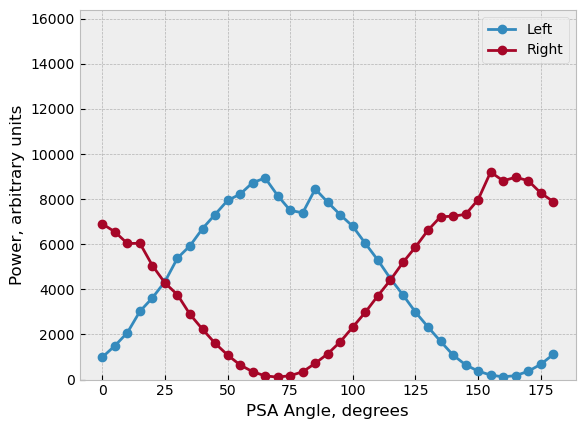

In [24]:
plt.style.use('bmh')
plt.figure()
plt.plot(angles_psa, power_psa_left, label='Left', marker='o')
plt.plot(angles_psa, power_psa_right, label='Right', marker='o')
plt.xlabel('PSA Angle, degrees')
plt.ylabel('Power, arbitrary units')
plt.ylim(0, 2**14)
plt.legend()
plt.show()

# Calibrate with Katsu model

In [121]:
from katsu.mueller import linear_retarder, linear_polarizer


def forward_experiment(x):

    starting_angle_psg_pol = x[0]
    starting_angle_psg_wvp = x[1]
    retardance_psg_wvp = x[2]
    increment_psg_wvp = 1 # x[3]

    starting_angle_psa_pol = x[4]
    starting_angle_psa_wvp = x[5]
    retardance_psa_wvp = x[6]
    increment_psa_wvp = 1 # x[7]

    # set up PSG angles
    psg_angles = np.arange(0, 180 + STEPS_DEG, STEPS_DEG) * increment_psg_wvp
    psg_lastval = psg_angles[-1]
    psg_lastval = np.full_like(psg_angles, psg_lastval)
    psg_angles = np.concatenate((psg_angles, psg_lastval))
    psg_angles = np.radians(psg_angles) + starting_angle_psg_wvp

    psa_angles = np.arange(0, 180 + STEPS_DEG, STEPS_DEG) * increment_psa_wvp
    psa_firstval = psa_angles[0]
    psa_firstval = np.full_like(psa_angles, psa_firstval)
    psa_angles = np.concatenate((psa_firstval, psa_angles))
    psa_angles = np.radians(psa_angles) + starting_angle_psa_wvp

    shapes = [psa_angles.shape[0]]


    psg_pol = linear_polarizer(starting_angle_psg_pol)
    psg_wvp = linear_retarder(psg_angles, retardance_psg_wvp, shape=shapes)

    psa_wvp = linear_retarder(psa_angles, retardance_psa_wvp, shape=shapes)
    psa_pol = linear_polarizer(starting_angle_psa_pol)

    Mtotal = psa_pol @ psa_wvp @ psg_wvp @ psg_pol


    return Mtotal[..., 0, 0]

def fwd_left(x):

    power_sim = forward_experiment(x)
    power_left = np.concatenate((power_psg_left, power_psa_left)) / 32000
    return np.sum((power_sim - power_left)**2)

def fwd_right(x):

    power_sim = forward_experiment(x)
    power_left = np.concatenate((power_psg_right, power_psa_right)) / 32000
    return np.sum((power_sim - power_left)**2)


In [129]:
from scipy.optimize import minimize
results = minimize(fwd_left, x0=[np.pi/2, 0, np.pi/2, 1, 0, 0, np.pi/2, 1], method='L-BFGS-B')

In [130]:
power_eval = forward_experiment(results.x)

In [131]:
print(results)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.04618040561883714
        x: [ 1.333e+00  6.285e-01  9.025e-01  1.000e+00  4.464e-02
            -4.358e-01  7.705e-01  1.000e+00]
      nit: 18
      jac: [ 1.618e-06 -5.829e-08 -9.673e-07  0.000e+00 -1.529e-06
             8.396e-08  2.914e-08  0.000e+00]
     nfev: 225
     njev: 25
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>


In [132]:
vals = ['PSG Pol angle', 'PSG WVP angle', 'PSG Ret', 'PSG Inc', 'PSA Pol angle', 'PSA WVP angle', 'PSA Ret', 'PSA Inc']
for res, val in zip(results.x, vals):
    print(f'{val}: {np.degrees(res)}')

PSG Pol angle: 76.40022733449588
PSG WVP angle: 36.012398726036984
PSG Ret: 51.70726661613288
PSG Inc: 57.29577951308232
PSA Pol angle: 2.5579483220335244
PSA WVP angle: -24.970651161701774
PSA Ret: 44.147953721881194
PSA Inc: 57.29577951308232


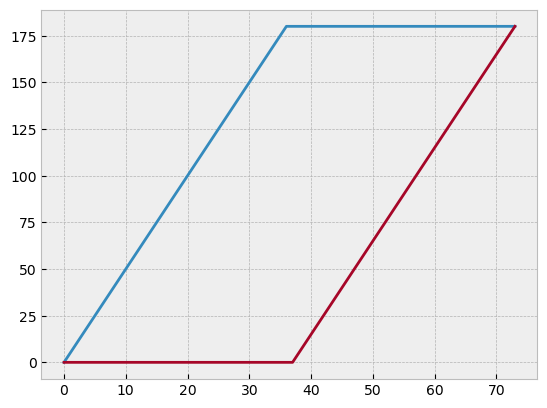

In [133]:
psg_angles = np.arange(0, 180 + STEPS_DEG, STEPS_DEG) 
psg_lastval = psg_angles[-1]
psg_lastval = np.full_like(psg_angles, psg_lastval)
psg_angles = np.concatenate((psg_angles, psg_lastval))

psa_angles = np.arange(0, 180 + STEPS_DEG, STEPS_DEG)
psa_firstval = psa_angles[0]
psa_firstval = np.full_like(psa_angles, psa_firstval)
psa_angles = np.concatenate((psa_firstval, psa_angles))

plt.plot(psg_angles)
plt.plot(psa_angles)

In [134]:
x0 = [np.pi/2, 0, np.pi/2, 1, 0, 0, np.pi/2, 1]
power = forward_experiment(x0)

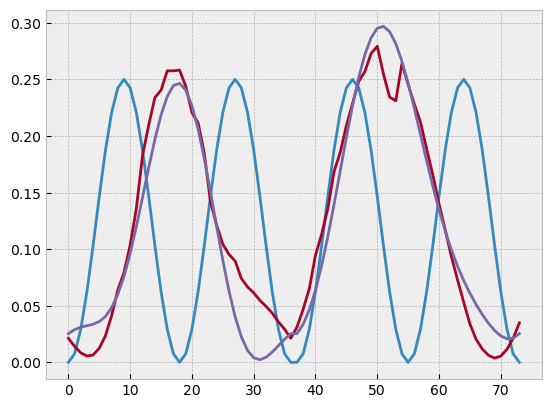

In [135]:
plt.plot(power)
plt.plot(np.concatenate((np.asarray(power_psg_left), np.asarray(power_psa_left)))/32000)
plt.plot(power_eval)

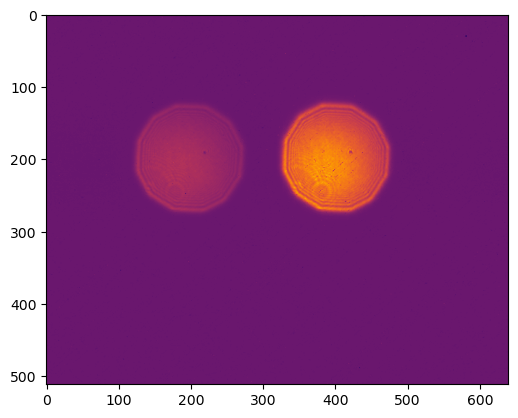

In [166]:
bright = cam.take_many_images(10)
bright_avg = np.mean(bright, axis=0) - dark_avg
plt.style.use('default')
plt.imshow(bright_avg, vmax=2**14, cmap='inferno')

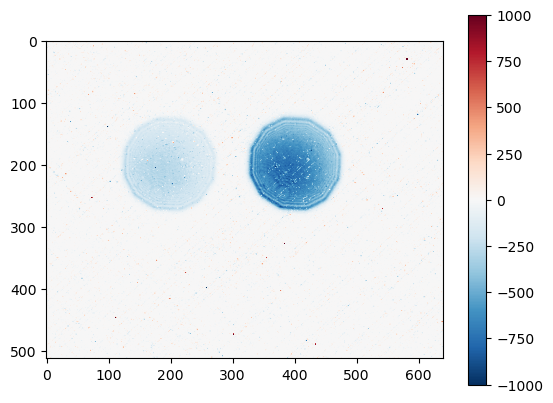

In [168]:
bright = cam.take_many_images(10)
bright_avg2 = np.mean(bright, axis=0) - dark_avg

plt.style.use('default')
plt.imshow(bright_avg2 - bright_avg, cmap='RdBu_r', vmin=-1000, vmax=1000)
plt.colorbar()

In [26]:
help(linear_retarder)

Help on function linear_retarder in module katsu.mueller:

linear_retarder(a, r, shape=None)
    returns a homogenous linear retarder

    Parameters
    ----------
    a : float, or numpy.ndarray
        angle of the fast axis w.r.t. horizontal in radians. If numpy array,
        must be 1D
    r : float, or numpy.ndarray
        retardance in radians. If numpy array, must be the same shape as
        `shape`
    shape : list, optional
        shape to prepend to the mueller matrix array, see `_empty_mueller`.
        by default None

    Returns
    -------
    numpy.ndarray
        linear retarder array



In [169]:
power_left = []
power_right = []

for th in angles_psg:

    _b = cam.take_many_images(10)
    _bm = np.mean(_b, axis=0) - dark_avg
    _bm[_bm < 0] = 1e-10
    power_left.append(np.mean(_bm[cxl-cut:cxl+cut, cyl-cut:cyl+cut][mask==1]))
    power_right.append(np.mean(_bm[cxr-cut:cxr+cut, cyr-cut:cyr+cut][mask==1]))

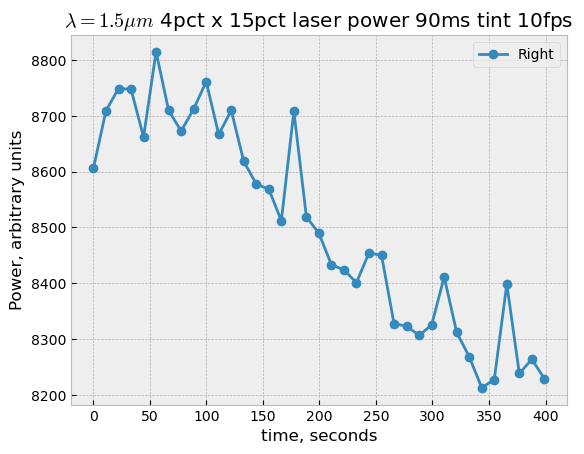

In [178]:
plt.style.use('bmh')
plt.figure()
plt.title(r'$\lambda=1.5\mu m$'+' 4pct x 15pct laser power 90ms tint 10fps ')
plt.plot(np.linspace(0, 6*60 + 39, len(power_right)), power_right, label='Right', marker='o')
plt.xlabel('time, seconds')
plt.ylabel('Power, arbitrary units')
plt.legend()
plt.show()

In [182]:
from derpy.camera import display_all_temps
display_all_temps(cam.context)

Sensor Temperature: -39.96C
Motherboard Temperature: 38.0C
Frontend Temperature: 42.5C
Powerboard Temperature: 44.75C
Peltier Temperature: 14.05C
Heatsink Temperature: 40.32C
***********************


-39.96

In [183]:
cam.close()
psg_stg.close()
psa_stg.close()